<a href="https://colab.research.google.com/github/ChefKeff/INF_1TE773_64687/blob/main/main_notebook_inf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pvlib

     |████████████████████████████████| 27.5 MB 1.3 MB/s 


In [ ]:
import os
import pandas as pd
import numpy as np
from pvlib import location, irradiance, pvsystem

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

my_path = '/content/drive/MyDrive/SKOLA/UU/INF PROJECT/Project - Infrastructure Systems/Progg/'   # Niklas Drive
#my_path = '/content/drive/MyDrive/Progg/'                       # Dolles Drive


Mounted at /content/drive


In [ ]:
df_data = pd.read_csv(my_path + 'model_data.csv')

# Define location parameters
lat, lon = 57.033110, 12.382547 # Coordinates to Varberg
tz = 'UTC'
site = location.Location(lat,lon,tz=tz)

df_dates = pd.date_range(start = str(df_data["Year"][0]) + "-" + str(df_data["Month"][0]) + "-" + str(df_data["Day"][0]) + " " + str(df_data["HourOfDay"][0]) + ":00:00", 
                         end = str(df_data["Year"].iloc[-1]) + "-" + str(df_data["Month"].iloc[-1]) + "-" + str(df_data["Day"].iloc[-1]) + " " + str(df_data["HourOfDay"].iloc[-1]) + ":00:00",
                         freq = "1H",
                         tz=site.tz)

df_wp = pd.DataFrame({'wp': df_data["Windfarm1"]}).set_index(pd.to_datetime(df_dates.values, utc = True))
df_irr = pd.DataFrame({'dhi': df_data["DHI"], 'dni': df_data["DNI"], 'ghi': df_data["GHI"]}).set_index(pd.to_datetime(df_dates.values, utc = True))
df_spot_price = pd.DataFrame({'spot': df_data["Price [SEK/MWh]"]/1000}).set_index(pd.to_datetime(df_dates.values, utc = True)) # SEK/kWh


In [118]:
def get_poa(site_location, date, irr, tilt, surface_azimuth):
    #clearsky = site_location.get_clearsky(date) # Get the clear sky irradiance
    solar_position = site_location.get_solarposition(times=date)
    POA_irradiance = irradiance.get_total_irradiance(surface_tilt=tilt,
                                                     surface_azimuth=surface_azimuth,
                                                     dni=irr["dni"],
                                                     ghi=irr["ghi"],
                                                     dhi=irr["dhi"],
                                                     solar_zenith=solar_position['apparent_zenith'],
                                                     solar_azimuth=solar_position['azimuth'],
                                                     albedo=0.2)
    return pd.DataFrame({'POA': POA_irradiance['poa_global']})

# Define module and inverter properties
module_parameters = {'pdc0': 100, 'gamma_pdc': -0.004}
inverter_parameters = {'pdc0': 100, 'eta_inv_nom': 0.96}
system = pvsystem.PVSystem(module_parameters=module_parameters,
                           inverter_parameters=inverter_parameters)

# Define system properties
solar_zenith = 0
panel_tilt = np.linspace(20, 70, 10)      # To be optimized
azimuth = np.linspace(150, 200, 10)         # To be optimized


In [119]:
limit = max(df_wp['wp'])                # Define transformer limit
max_curtail = 1.05                         # Maximum allowed curtailment in percent [%]
eff = 0.17                              # Efficiency of PV system

# Declare dataframes for saving
capacity_results = pd.DataFrame([], columns = ['Tilt', 'Azimuth', 'Capacity [kW]'])

wind = df_wp["wp"].to_numpy()

for tilt in panel_tilt:
    azi_count = 0
    for azi in azimuth:
        curtailed = 0
        latest_curt = 0
        area = 10 # In m^2

        df_poa = get_poa(site, df_dates, df_irr, tilt, azi) # We get this in W/m^2
        pv = (df_poa*area*eff) # PV power output. Since df_poa is given in W/m^2, multiplying by area (m^2), we can get power output in Watts
        pv = pv.to_numpy()

        while curtailed <= max_curtail:
            latest_curt = curtailed
            pv_output = np.ravel(df_poa)*area*0.17
            curtailment = np.minimum(np.repeat(limit, len(pv)) - (wind + pv_output), np.repeat(0, len(pv)))
            curtailed = (np.abs(np.sum(curtailment)) + np.sum(wind)) / (limit * len(pv))
            area = area + 10            # Might be too or too litte to add 10 m^2

        capacity_results = capacity_results.append({'Tilt': round(tilt,3), 'Azimuth': round(azi,3), 'Area [M2]': (area-10), 'Capacity [kW]': np.sum(pv_output), 'Tot curt': latest_curt}, ignore_index = True)

    Tilt  Azimuth  Capacity [kW]  Area [M2]  Tot curt
0   20.0  150.000   4.879389e+07      260.0  1.026466
1   20.0  155.556   4.907132e+07      260.0  1.031949
2   20.0  161.111   4.929632e+07      260.0  1.036434
3   20.0  166.667   4.947098e+07      260.0  1.039870
4   20.0  172.222   4.959312e+07      260.0  1.042194
..   ...      ...            ...        ...       ...
95  80.0  177.778   4.896818e+07      310.0  1.047288
96  80.0  183.333   4.899198e+07      310.0  1.048001
97  80.0  188.889   4.900372e+07      310.0  1.047940
98  80.0  194.444   4.893002e+07      310.0  1.046249
99  80.0  200.000   4.872878e+07      310.0  1.042170

[100 rows x 5 columns]


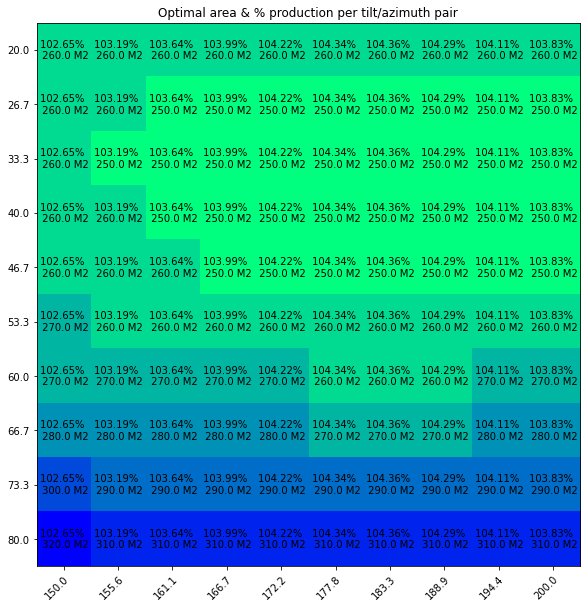

In [121]:
print(capacity_results)
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

area_list = []

curt_list = []

sub_arr = []
sub_curt = []

def normalize(index, arr):
  return (arr[index] - min(arr)) / (max(arr) - min(arr))


for index in range(len(panel_tilt)**2):
  if len(sub_arr) is not len(panel_tilt):
    sub_arr.append(capacity_results['Area [M2]'].iloc[index])
    sub_curt.append(capacity_results['Tot curt'])
  else:
    area_list.append(sub_arr)
    curt_list.append(sub_curt)
    sub_arr = []
    curr_tilt = capacity_results['Tilt'].iloc[index]
    sub_arr.append(capacity_results['Area [M2]'].iloc[index])
    sub_curt.append(capacity_results['Tot curt'])


area_list.append(sub_arr)
curt_list.append(sub_curt)

area_np = np.array(area_list)
curt_np = np.array(sub_curt)

color_map = plt.cm.get_cmap('winter').reversed()

plt.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
im = ax.imshow(area_np, cmap=color_map)

# Setting the labels
ax.set_xticks(np.arange(len(azimuth)))
ax.set_yticks(np.arange(len(panel_tilt)))
# labeling respective list entries
ax.set_xticklabels(azimuth.round(decimals=1, out=None))
ax.set_yticklabels(panel_tilt.round(decimals=1, out=None))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Creating text annotations by using for loop
for i in range(len(panel_tilt)):
    for j in range(len(azimuth)):
        text = ax.text(j, i, f'{(100*curt_np[i, j]).round(decimals=2, out=None)}% \n {area_np[i,j]} M2',
                       ha="center", va="center")

ax.set_title("Optimal area & % production per tilt/azimuth pair")
plt.show()